<h2>Quick Start: Creating Sample-wise Unlearnable Examples</h2>

In [17]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from torch.utils.data import DataLoader
from transformers import AdamW
from transformers import get_scheduler
from tqdm import tqdm
import numpy as np
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

<h3>Prepare Data</h3>

In [18]:

# prepare dataset: text -> vectors
checkpoint = "distilbert-base-uncased"
datasets = load_dataset("data_scripts/glue.py", "sst2")
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["sentence"], truncation=True)

tokenized_datasets = datasets.map(tokenize_function, batched=True)

tokenized_datasets = tokenized_datasets.remove_columns(
    ["sentence", "idx"]
)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")



Reusing dataset glue (/home/xinzhel/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


<h3> Prepare Model</h3>

In [3]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
model.to(device)



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

<h3>Train</h3>

In [31]:
def get_grad(batch, model):
    """ This is compatible with Huggingface transformers: 
    batch is the `tokenizer` output;
    model is the subclass of the `PreTrainedModel`
    """
    model_device = next(model.parameters()).device
    batch = {k: v.to(device) for k, v in batch.items()}
    model.train()
    embedding_layer = model.get_input_embeddings()
    original_state = embedding_layer.weight.requires_grad
    embedding_layer.weight.requires_grad = True

    emb_grads = []

    def grad_hook(module, grad_in, grad_out):
        emb_grads.append(grad_out[0])

    # layer input: (8, 33) ; layer output: (8, 33, 768)
    emb_hook = embedding_layer.register_full_backward_hook(grad_hook)

    model.zero_grad()

    outputs = model(**batch)
    loss = outputs.loss
    loss.backward()
    grad = emb_grads[0]
    embedding_layer.weight.requires_grad = original_state
    emb_hook.remove()
    model.eval()
    return grad


In [14]:
# batch = next(iter(train_loader))
def min_min_attack(batch, model, max_swap=1):
    """ The objective is to minimize:
        L = L(orig_text) + [replace_token - orig_text[i]].dot(input_grad)
    """
    device = next(model.parameters()).device
    grad = get_grad(batch, model)
    embedding_matrix = model.get_input_embeddings().weight

    # first-order approximate
    # ignore `src_embeds` since it is constant and does not affect the result
    # src_embeds = model.get_input_embeddings()(batch["input_ids"].to(device))

    first_order_dir = torch.einsum("bij,kj->bik", (grad, embedding_matrix)) # - torch.einsum("bij,bij->bi", (input_gradients, src_embeds))
    first_order_dir[:,[0,1],:] = np.inf # all replacements for the first two tokens are invalid.
    first_order_dir[batch['attention_mask']==0] = np.inf

    # apply constraints if necessary

    # find the best position and its replacement to minimize loss
    score_at_each_step, best_at_each_step = (-first_order_dir).max(2)
    _, best_positions = score_at_each_step.topk(max_swap)
    replacment_for_best_positions = best_at_each_step.gather(dim=1, index=best_positions.clone())

    return best_positions, replacment_for_best_positions
    


In [26]:

condition = True
train_idx = 0
M = 100
max_swap = 1

best_positions = torch.ones([len(datasets['train']), max_swap], dtype=torch.int64) +1
replacment_for_best_positions = torch.ones([len(datasets['train']), max_swap], dtype=torch.int64) * 624


# prepare dataloader for batching and in-batch padding
batch_size = 32
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_loader = DataLoader(
    tokenized_datasets["train"], shuffle=False, batch_size=batch_size, collate_fn=data_collator
)
eval_loader = DataLoader(
    tokenized_datasets["validation"], shuffle=False, batch_size=batch_size, collate_fn=data_collator
)
data_iter = iter(train_loader)

def eval_metrix(model, eval_loader):
    total = 0
    correct = 0
    for batch in eval_loader:
        with torch.no_grad():
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            total += batch['labels'].size(0)
            correct += (predicted == batch['labels']).sum().item()
    acc = correct / total
    return acc


In [ ]:
# optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)
# num_epochs = 3
# num_training_steps = num_epochs * len(train_loader) 
# for _ in range(num_training_steps):
acc=0
eval_metrix = []
while acc < 0.85:
    # optimize theta for M steps
    model.train()
    for param in model.parameters():
        param.requires_grad = True
    for j in range(0, M):
        try:
            batch = next(data_iter)
        except:
            train_idx = 0
            data_iter = iter(train_loader)
            batch = next(data_iter)

        # update adv example into batch
        batch['input_ids'].scatter_(dim=1, index=best_positions[train_idx:(train_idx+batch_size)], src=replacment_for_best_positions[train_idx:(train_idx+batch_size)])
                
        
        train_idx += batch_size

        model.zero_grad()
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        outputs.loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        # record the accuracy on eval
        # eval_metrix.append(eval(model, eval_loader))
    
    # Perturbation over entire dataset
    idx = 0
    for param in model.parameters():
        param.requires_grad = False
    for i, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
        best_positions[idx:(idx+batch_size)], replacment_for_best_positions[idx:(idx+batch_size)] = min_min_attack(batch, model, max_swap=1)
        idx = idx + batch_size



    # Eval stop condition
    eval_idx, total, correct = 0, 0, 0
    for i, batch in enumerate(train_loader):
        # update adv example into batch
        batch['input_ids'].scatter_(dim=1, index=best_positions[eval_idx:(eval_idx+batch_size)], src=replacment_for_best_positions[eval_idx:(eval_idx+batch_size)])
        with torch.no_grad():
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            _, predicted = torch.max(outputs.logits, 1)
            total += batch['labels'].size(0)
            correct += (predicted == batch['labels']).sum().item()
        
        eval_idx = eval_idx + batch_size
    acc = correct / total

    print('Accuracy %.2f' % (acc*100))

# save unlearnable modifications 
import pickle
modifications = dict()
for idx, (i,j) in enumerate(zip(list(best_positions.squeeze().numpy()), list(replacment_for_best_positions.squeeze().numpy()))):
    modifications[idx] = (i,j)
with open("modification_sst2.json", 'wb') as fp:
    pickle.dump(modifications, fp)



In [60]:
with open('result/modification_sst2_M10.json', 'rb') as fp:
        m = pickle.load(fp)
best_positions = []
replacment_for_best_positions = []
for i,j in m.values():
    best_positions.append(i)
    replacment_for_best_positions.append(j)
best_positions = torch.tensor(best_positions, dtype=torch.int64).unsqueeze(1)
replacment_for_best_positions = torch.tensor(replacment_for_best_positions, dtype=torch.int64).unsqueeze(1)

replacement_tokens = tokenizer.convert_ids_to_tokens(replacment_for_best_positions)
labels = datasets['train']['label']
for i, j in zip(replacement_tokens[:20], labels[:20]):
    print(i,j)

packet 0
chow 0
ebook 1
dummy 0
squads 0
hysteria 0
##tiv 1
##tia 1
##oom 0
inspiring 1
stale 0
##ª 0
##shed 0
zoning 0
stale 0
##eth 1
##tery 0
qualities 1
[CLS] 0
inspiring 1


<h3>Creat Unlearnable Dataset</h3>

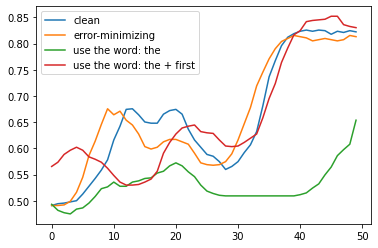

In [1]:
import pickle
with open("result/train_M10iter50_unlearnable_distil.txt", "rb") as fp:
    eval_accuracy_unlearnable = pickle.load(fp)

with open("result/train_M10iter50_distil.txt", "rb") as fp:
    eval_accuracy = pickle.load(fp)

with open("result/train_M10iter50_the_distil.txt", "rb") as fp:
    eval_accuracy_the = pickle.load(fp)

with open("result/train_M10iter50_the1_distil.txt", "rb") as fp:
    eval_accuracy_the1 = pickle.load(fp)


import matplotlib.pyplot as plt
plt.plot(eval_accuracy, label='clean')
plt.plot(eval_accuracy_unlearnable, label='error-minimizing')
plt.plot(eval_accuracy_the, label='use the word: the')
plt.plot(eval_accuracy_the1, label='use the word: the + first')
plt.legend()